<a href="https://colab.research.google.com/github/honi-sm/AmphiBIO_TraitAnalysisFinal/blob/main/001AssumptionsTestPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Model Assumptions and Diagnostics

# Notebook Purpose
#This notebook evaluates statistical assumptions and model diagnostics for inferential
#analyses conducted in `02_inferential_statistics.ipynb`.

# All preprocessing, feature engineering, and distributional checks used to guide data
#transformation were performed upstream. This notebook does not modify the dataset and does not
#perform confirmatory hypothesis testing.

In [ ]:
#fetch from github
!git clone https://github.com/honi-sm/AmphiBIO_TraitAnalysisFinal.git

import os
os.chdir("/content/AmphiBIO_TraitAnalysisFinal")

Cloning into 'AmphiBIO_TraitAnalysisFinal'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 106 (delta 37), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (106/106), 2.77 MiB | 8.59 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.diagnostic import het_breuschpagan\

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
#Get the sample in here
for root, dirs, files in os.walk(".", topdown=True):
    for name in files:
        if "sample500" in name:
            print(os.path.join(root, name))

./Data/Processed/sample500_with_logs (1).csv
./AmphiBIO_TraitAnalysisFinal/Data/Processed/sample500_with_logs (1).csv


In [ ]:
"""
AmphiBIO Assumption Checks + Model Diagnostics
Author: Lia Grace Stratos
Institution: University of Nebraska Omaha
Date: December 2025

Purpose:
Run assumption checks and diagnostics on the cleaned, log10-transformed
500-species AmphiBIO sample (seed = 2025). Explores which inferential to support the
in later notebooks (Welch ANOVA, Games–Howell, Spearman, and robust regression).

Methods/Assumptions:
- Briefly justify log10 transforms (skew reduction), and explain
  why robust/heteroskedasticity-tolerant methods were used where needed.
- Results: Any clear non-normality or unequal variance?

Inputs:
- Cleaned dataset: 500-species random sample (seed = 2025)
- Raw continuous traits:
    * bodyLengthMm
    * clutchSizeMinN
    * clutchSizeMaxN
- Log10 continuous traits:
    * logBodyLengthMm
    * logClutchSizeMinN
    * logClutchSizeMaxN
- Categorical variables:
    * reproductiveMethod (direct / larval / viviparous)
    * habitatClass (from habitatType)

Checks performed:
A) Distribution shape + normality
   - hist/violin plots: raw vs log10
   - Shapiro–Wilk
   - Q–Q plots
B) Homogeneity/heteroskedasticity screening
   - Levene’s test across reproductiveMethod
   - residual plots for OLS models
   - robust SE comparison (HC3)
C) Regression model check
   - linearity/outlier
   - residual diagnostics
   - heteroskedasticity flags

Outputs:
- Tables: Shapiro results, Levene results, raw vs log10 distribution comparisons,
diagnostic plots
"""

'\nAmphiBIO Assumption Checks + Model Diagnostics\nAuthor: Lia Grace Stratos\nInstitution: University of Nebraska Omaha\nDate: December 2025\n\nPurpose:\nRun assumption checks and diagnostics on the cleaned, log10-transformed\n500-species AmphiBIO sample (seed = 2025). Explores which inferential to support the\nin later notebooks (Welch ANOVA, Games–Howell, Spearman, and robust regression).\n\nMethods/Assumptions:\n- Briefly justify log10 transforms (skew reduction), and explain\n  why robust/heteroskedasticity-tolerant methods were used where needed.\n- Results: Any clear non-normality or unequal variance?\n\nInputs:\n- Cleaned dataset: 500-species random sample (seed = 2025)\n- Raw continuous traits:\n    * bodyLengthMm\n    * clutchSizeMinN\n    * clutchSizeMaxN\n- Log10 continuous traits:\n    * logBodyLengthMm\n    * logClutchSizeMinN\n    * logClutchSizeMaxN\n- Categorical variables:\n    * reproductiveMethod (direct / larval / viviparous)\n    * habitatClass (from habitatType)\n

In [ ]:
# LIBRARY SETUP
from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Tuple
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro, levene
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Schema
@dataclass(frozen=True)
class ColumnSpec:
    name: str
    dtype: str
    description: str
    allowed: Optional[List[str]] = None
    source: Optional[str] = None
    transform: Optional[str] = None
    usedIn: Optional[List[str]] = None


columnSpecs: Dict[str, ColumnSpec] = {
    "Species": ColumnSpec(
        name="Species",
        dtype="string",
        description="Species scientific name (unique ID)",
        source="input",
        usedIn=["QA", "reporting"]
    ),

    "habitatType": ColumnSpec(
        name="habitatType",
        dtype="string",
        description="Raw habitat composite label (contains '+' for combos)",
        source="input",
        usedIn=["habitatClass construction"]
    ),

    "habitatClass": ColumnSpec(
        name="habitatClass",
        dtype="category",
        description="Habitat category collapsed from habitatType (concise)",
        source="made",
        transform="classifyHabitat(habitatType)",
        allowed=[
            "aquatic-only", "aquatic-associated",
            "arboreal-only", "arboreal-associated",
            "terrestrial-only", "terrestrial-associated",
            "generalist", "other"
        ],
        usedIn=["group checks", "stratified assumptions", "plots"]
    ),

    "reproductiveMethod": ColumnSpec(
        name="reproductiveMethod",
        dtype="category",
        description="Reproductive mode category",
        source="input or made",
        allowed=["direct", "larval", "viviparous"],
        usedIn=["levene by group", "diagnostic plots", "stratified shapiro"]
    ),

    "bodyLengthMm": ColumnSpec(
        name="bodyLengthMm",
        dtype="numeric",
        description="Body length in millimeters (raw scale)",
        source="input",
        usedIn=["raw vs log visuals"]
    ),

    "clutchSizeMinN": ColumnSpec(
        name="clutchSizeMinN",
        dtype="numeric",
        description="Minimum clutch size (count)",
        source="input",
        usedIn=["raw vs log visuals"]
    ),

    "clutchSizeMaxN": ColumnSpec(
        name="clutchSizeMaxN",
        dtype="numeric",
        description="Maximum clutch size (count)",
        source="input",
        usedIn=["raw vs log visuals", "regression diagnostics (raw scale preview)"]
    ),

    "logBodyLengthMm": ColumnSpec(
        name="logBodyLengthMm",
        dtype="numeric",
        description="log10(bodyLengthMm)",
        source="made or input",
        transform="log10(bodyLengthMm)",
        usedIn=["normality screening", "regression diagnostics"]
    ),

    "logClutchSizeMinN": ColumnSpec(
        name="logClutchSizeMinN",
        dtype="numeric",
        description="log10(clutchSizeMinN)",
        source="made or input",
        transform="log10(clutchSizeMinN)",
        usedIn=["normality screening"]
    ),

    "logClutchSizeMaxN": ColumnSpec(
        name="logClutchSizeMaxN",
        dtype="numeric",
        description="log10(clutchSizeMaxN)",
        source="made or input",
        transform="log10(clutchSizeMaxN)",
        usedIn=["normality screening", "regression diagnostics"]
    ),
}

# Standardize names w/aliases
columnAliases: Dict[str, str] = {
    "log_bodyLengthMm": "logBodyLengthMm",
    "log_clutchSizeMinN": "logClutchSizeMinN",
    "log_clutchSizeMaxN": "logClutchSizeMaxN",
    "HabitatClass": "habitatClass",
    "HabitatType": "habitatType",
    "ReproductiveMethod": "reproductiveMethod",
}

# Build habitatClass
def classifyHabitat(h) -> str:
    """Collapse habitatType combos into a smaller set of analysis categories"""
    if pd.isna(h):
        return "other"

    parts = [p.strip().lower() for p in str(h).split("+") if p.strip()]
    n = len(parts)

    hasT  = "terrestrial" in parts
    hasAq = "aquatic" in parts
    hasAr = "arboreal" in parts

    if n >= 3:
        return "generalist"
    if n == 1 and hasAq:
        return "aquatic-only"
    if hasAq and n == 2:
        return "aquatic-associated"
    if n == 1 and hasT:
        return "terrestrial-only"
    if hasT and n == 2:
        return "terrestrial-associated"
    if n == 1 and hasAr:
        return "arboreal-only"
    if hasAr and n == 2 and (not hasAq) and (not hasT):
        return "arboreal-associated"
    return "other"

def addHabitatClass(df: pd.DataFrame, source_col: str = "habitatType", out_col: str = "habitatClass") -> pd.DataFrame:
    """Add habitatClass if missing."""
    if source_col not in df.columns:
        raise KeyError(f"{source_col} column missing for {out_col}.")
    df = df.copy()
    df[out_col] = df[source_col].apply(classifyHabitat).astype("string")
    return df

# Helper functions normalization
def showDataLibrary() -> pd.DataFrame:
    """Pretty summary"""
    rows = []
    for spec in columnSpecs.values():
        rows.append({
            "column": spec.name,
            "dtype": spec.dtype,
            "description": spec.description,
            "allowed": ", ".join(spec.allowed) if spec.allowed else "",
            "source": spec.source or "",
            "transform": spec.transform or "",
            "usedIn": ", ".join(spec.usedIn) if spec.usedIn else "",
        })
    return pd.DataFrame(rows)

def standardizeColumnNames(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize aliases"""
    return df.rename(columns={k: v for k, v in columnAliases.items() if k in df.columns})

def normalizeCategoricals(df: pd.DataFrame) -> pd.DataFrame:
    """Lowercase/strip categoricals (safe normalization for plotting + tables)"""
    df = df.copy()
    for col in ["reproductiveMethod", "habitatType", "habitatClass"]:
        if col in df.columns:
            df[col] = df[col].astype("string").str.strip().str.lower()

    for col in ["reproductiveMethod", "habitatClass"]:
        if col in df.columns:
            df[col] = df[col].astype("category")

    return df

def validateSchema(df: pd.DataFrame, strict: bool = True) -> Dict[str, Any]:
    """
    Presence + type + allowed categories.
    strict=True raises; strict=False returns issues dict
    """
    issues = {"missing": [], "badType": [], "badValues": []}

    for name, spec in columnSpecs.items():
        if name not in df.columns:
            issues["missing"].append(name)
            continue

        if spec.dtype == "numeric":
            if not pd.api.types.is_numeric_dtype(df[name]):
                issues["badType"].append((name, str(df[name].dtype), "numeric"))

        elif spec.dtype in ("string", "category"):
            if str(df[name].dtype) not in ("string", "object", "category"):
                issues["badType"].append((name, str(df[name].dtype), spec.dtype))

        if spec.allowed:
            observed = set(df[name].dropna().astype("string").str.lower().unique())
            allowed = set(a.lower() for a in spec.allowed)
            bad = sorted(list(observed - allowed))
            if bad:
                issues["badValues"].append((name, bad))

    if strict and (issues["missing"] or issues["badType"] or issues["badValues"]):
        msg = ["SCHEMA VALIDATION FAILED"]
        if issues["missing"]:
            msg.append(f"Missing: {issues['missing']}")
        if issues["badType"]:
            msg.append(f"Bad dtypes: {issues['badType']}")
        if issues["badValues"]:
            msg.append(f"Bad categorical values: {issues['badValues']}")
        raise ValueError("\n".join(msg))

    return issues

RAW_TRAITS = ["bodyLengthMm", "clutchSizeMinN", "clutchSizeMaxN"]
LOG_TRAITS = ["logBodyLengthMm", "logClutchSizeMinN", "logClutchSizeMaxN"]

RAW_LOG_PAIRS: List[Tuple[str, str]] = [
    ("bodyLengthMm", "logBodyLengthMm"),
    ("clutchSizeMinN", "logClutchSizeMinN"),
    ("clutchSizeMaxN", "logClutchSizeMaxN"),
]

# Preddy colors
jewel = ["#6A5ACD", "#20B2AA", "#C77DFF", "#FF6B6B", "#4CC9F0"]
jewel_dark = ["#4B3FA6", "#1C8C7D", "#9F5ACC", "#CC5555", "#379AC2"]

PALETTE_REPRO = {
    "larval": jewel[0],
    "direct": jewel[1],
    "viviparous": jewel[2],
}

RANDOM_SEED = 2025

def shapiro_screen(series: pd.Series, max_n: int = 5000, seed: int = RANDOM_SEED) -> Dict[str, Any]:
    """
    Shapiro–Wilk normality
    """
    vals = pd.to_numeric(series, errors="coerce").dropna()
    n = len(vals)
    if n == 0:
        return {"N": 0, "W": np.nan, "p": np.nan}

    if n > max_n:
        vals = vals.sample(max_n, random_state=seed)
        n = len(vals)

    W, p = shapiro(vals)
    return {"N": n, "W": float(W), "p": float(p)}

def levene_by_group(df: pd.DataFrame, y: str, group: str = "reproductiveMethod") -> Dict[str, Any]:
    """
    Levene’s test for equal variances across groups
    """
    sub = df[[y, group]].copy()
    sub[y] = pd.to_numeric(sub[y], errors="coerce")
    sub = sub.dropna(subset=[y, group])

    groups = []
    for gval, gdf in sub.groupby(group):
        groups.append(gdf[y].values)

    if len(groups) < 2:
        return {"test": "Levene", "y": y, "group": group, "W": np.nan, "p": np.nan}

    W, p = levene(*groups, center="median")
    return {"test": "Levene", "y": y, "group": group, "W": float(W), "p": float(p)}


def fit_ols_with_hc3(formula: str, df: pd.DataFrame) -> Dict[str, Any]:
    """
    Fit OLS and HC3 robust SE(for heteroskedasticity protection)
    """
    model = smf.ols(formula, data=df).fit()
    robust = model.get_robustcov_results(cov_type="HC3")
    return {"ols": model, "hc3": robust}


# Table of Contents
print("Sections:")
print("1) Freeze dataset + schema check")
print("2) habitatClass build")
print("3) Raw vs log10 distribution visuals")
print("4) Shapiro–Wilk screening est")
print("5) Levene variance checks across reproductiveMethod")
print("6) ANOVA Assumption Check")
print("7) WELCH ANOVA Assumption Check")
print("8) Regression diagnostics + robust SE (HC3)")
print("9) Export tables/figures")

display(showDataLibrary())

Sections:
1) Freeze dataset + schema check
2) habitatClass build
3) Raw vs log10 distribution visuals
4) Shapiro–Wilk screening est
5) Levene variance checks across reproductiveMethod
6) ANOVA Assumption Check
7) WELCH ANOVA Assumption Check
8) Regression diagnostics + robust SE (HC3)
9) Export tables/figures


,column,dtype,description,allowed,source,transform,usedIn
0,Species,string,Species scientific name (unique ID),,input,,"QA, reporting"
1,habitatType,string,Raw habitat composite label (contains '+' for ...,,input,,habitatClass construction
2,habitatClass,category,Habitat category collapsed from habitatType (c...,"aquatic-only, aquatic-associated, arboreal-onl...",made,classifyHabitat(habitatType),"group checks, stratified assumptions, plots"
3,reproductiveMethod,category,Reproductive mode category,"direct, larval, viviparous",input or made,,"levene by group, diagnostic plots, stratified ..."
4,bodyLengthMm,numeric,Body length in millimeters (raw scale),,input,,raw vs log visuals
5,clutchSizeMinN,numeric,Minimum clutch size (count),,input,,raw vs log visuals
6,clutchSizeMaxN,numeric,Maximum clutch size (count),,input,,"raw vs log visuals, regression diagnostics (ra..."
7,logBodyLengthMm,numeric,log10(bodyLengthMm),,made or input,log10(bodyLengthMm),"normality screening, regression diagnostics"
8,logClutchSizeMinN,numeric,log10(clutchSizeMinN),,made or input,log10(clutchSizeMinN),normality screening
9,logClutchSizeMaxN,numeric,log10(clutchSizeMaxN),,made or input,log10(clutchSizeMaxN),"normality screening, regression diagnostics"


In [ ]:
# prep
from typing import Optional, List, Dict, Any

class DatasetBase:
    """
    wrapper for loading + lightweight metadata logging
    """
    def __init__(self, dataPath: str):
        self.dataPath = dataPath
        self.df: Optional[pd.DataFrame] = None

    def load(self) -> "DatasetBase":
        self.df = pd.read_csv(self.dataPath)
        print(f"Loaded: {self.dataPath}")
        print(f"Shape: {self.df.shape}")
        return self


class AmphiBIODataset(DatasetBase):
    """
    AmphiBIO analysis wrapper
    """

    # Assumptions
    RAW_TRAITS = ["bodyLengthMm", "clutchSizeMinN", "clutchSizeMaxN"]
    LOG_TRAITS = ["logBodyLengthMm", "logClutchSizeMinN", "logClutchSizeMaxN"]
    GROUP_COLS = ["reproductiveMethod", "habitatClass", "habitatType"]

    def prep(self, strict_schema: bool = False, verbose: bool = True) -> "AmphiBIODataset":
        """
        PREP (Assumptions):
        1) Standardize names
        2) Normalize categoricals (strip/lower + set category dtype)
        3) Create habitatClass from habitatType if missing
        4) Coerce numeric trait columns to numeric
        5) Validate schema
        6) Print QA
        """
        if self.df is None:
            raise RuntimeError("Call .load() before .prep().")

        df = self.df.copy()

        # 1) standardize
        df = standardizeColumnNames(df)

        # 2) normalize categoricals
        df = normalizeCategoricals(df)

        # 3) make habitatClass if it din't i think
        if "habitatClass" not in df.columns and "habitatType" in df.columns:
            df = addHabitatClass(df)

        # 4) numeric check
        for col in (self.RAW_TRAITS + self.LOG_TRAITS):
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        # 5) schema check
        issues = validateSchema(df, strict=strict_schema)

        # 6) QA
        if verbose:
            print("weeeeee")
            print(f"Final shape: {df.shape}")

            # Missingness summary for traits
            trait_cols = [c for c in (self.RAW_TRAITS + self.LOG_TRAITS) if c in df.columns]
            if trait_cols:
                miss = df[trait_cols].isna().sum().sort_values(ascending=False)
                print("\nMissing values (traits):")
                print(miss.to_string())

            # Group counts
            for g in ["reproductiveMethod", "habitatClass"]:
                if g in df.columns:
                    print(f"\nCounts: {g}")
                    print(df[g].value_counts(dropna=False).to_string())

            # Show schema issues
            if issues and any(len(v) for v in issues.values()):
                print("\nSchema issues (non-strict mode):")
                print(issues)

        self.df = df
        return self

    def freeze_analysis(self) -> pd.DataFrame:
        """
        Return a frozen copy of data and prep
        """
        if self.df is None:
            raise RuntimeError("Call .load().prep() before .freeze_analysis().")
        return self.df.copy()

In [ ]:
DATA_PATH = "./AmphiBIO_TraitAnalysisFinal/Data/Processed/sample500_with_logs (1).csv"

ds = (
    AmphiBIODataset(DATA_PATH)
    .load()
    .prep(strict_schema=False)
)

df_analysis = ds.freeze_analysis()
del ds

Loaded: ./AmphiBIO_TraitAnalysisFinal/Data/Processed/sample500_with_logs (1).csv
Shape: (500, 9)
weeeeee
Final shape: (500, 10)

Missing values (traits):
bodyLengthMm         0
clutchSizeMinN       0
clutchSizeMaxN       0
logBodyLengthMm      0
logClutchSizeMinN    0
logClutchSizeMaxN    0

Counts: reproductiveMethod
reproductiveMethod
larval        416
direct         82
viviparous      2

Counts: habitatClass
habitatClass
generalist                191
aquatic-associated        167
terrestrial-associated     70
terrestrial-only           46
arboreal-only              16
other                       6
aquatic-only                4


In [ ]:
# checks
assert df_analysis["Species"].is_unique, \
    "Dataset must have exactly one row per species."

assert df_analysis.shape[0] == 500, \
    f"Expected 500 rows, found {df_analysis.shape[0]}."

REQUIRED_COLUMNS = {
    "Species",
    "bodyLengthMm",
    "clutchSizeMinN",
    "clutchSizeMaxN",
    "habitatType",
    "logBodyLengthMm",
    "logClutchSizeMinN",
    "logClutchSizeMaxN",
}

missing = REQUIRED_COLUMNS - set(df_analysis.columns)
assert not missing, f"Missing required columns: {missing}"

print("All good")

All good


In [ ]:
# shit I forgot checks
assert "habitatClass" in df_analysis.columns, \
    "habitatClass column missing."

n_missing = df_analysis["habitatClass"].isna().sum()
assert n_missing == 0, \
    f"habitatClass contains {n_missing} NA values."

# 3) Allowed categories only
ALLOWED_HABITATS = {
    "aquatic-only",
    "aquatic-associated",
    "arboreal-only",
    "arboreal-associated",
    "terrestrial-only",
    "terrestrial-associated",
    "generalist",
    "other",
}

observed = set(df_analysis["habitatClass"].unique())
unexpected = observed - ALLOWED_HABITATS

assert not unexpected, \
    f"Unexpected habitatClass values found: {unexpected}"

In [ ]:
#data prep complete
# 1) Raw vs log10 distribution visuals
# 2) Shapiro–Wilk
# 3) Levene variance checks across reproductiveMethod
# 3.5) Chi-square screening: habitatClass × reproductiveMethod
# 4) ANOVA Assumption Check
# 5) WELCH ANOVA Assumption Check
# 6) Regression diagnostics + robust SE (HC3)
# 7) Export tables/figures

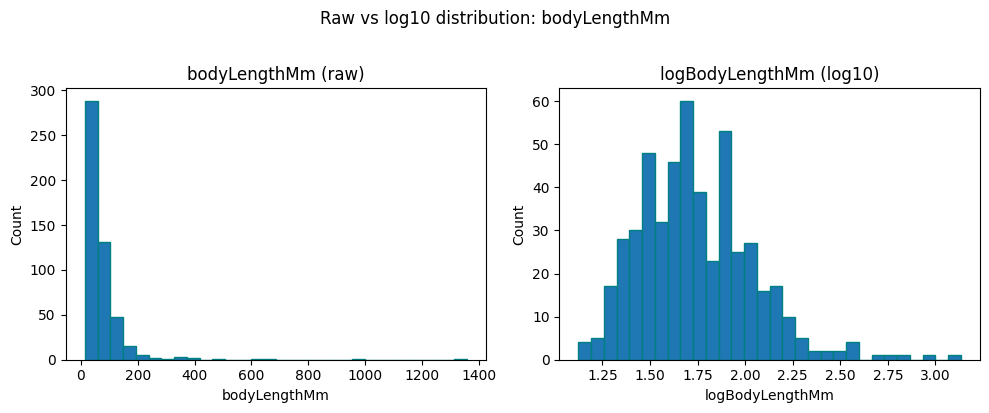

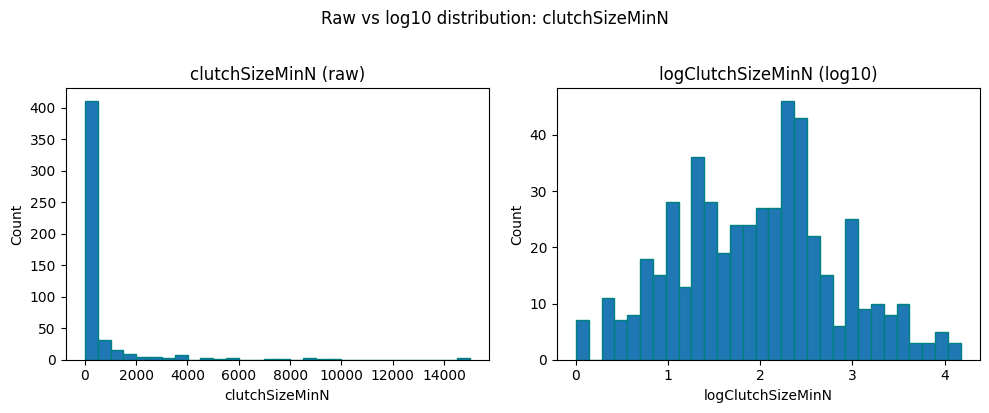

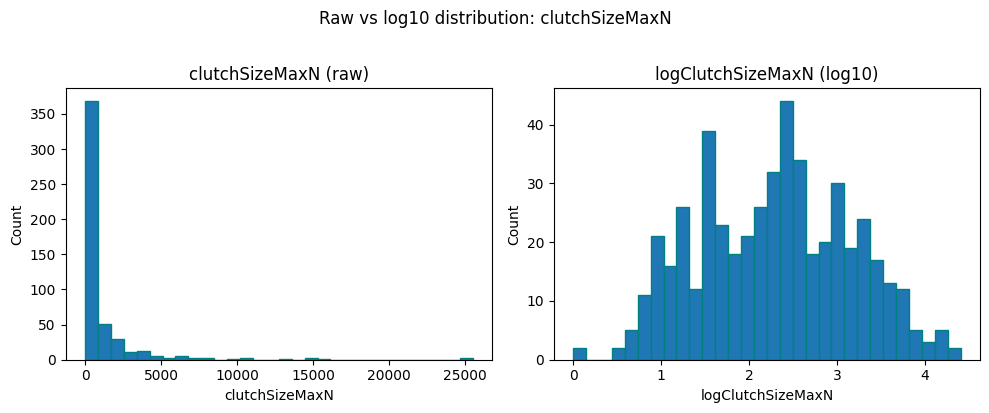

In [ ]:
# 1) RAW vs LOG10 DISTRIBUTION VISUALS (Assumptions)
"""
- Side-by-side visuals of raw vs log10 traits
- Show log10 transforms
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# column names in library match
raw_log_pairs = [
    ("bodyLengthMm",    "logBodyLengthMm"),
    ("clutchSizeMinN",  "logClutchSizeMinN"),
    ("clutchSizeMaxN",  "logClutchSizeMaxN"),
]

def _safe_series(df, col):
    """Numeric-safe extraction."""
    if col not in df.columns:
        return None
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    return s if len(s) else None

def plot_raw_vs_log(df, pairs, bins=30):
    for raw, log in pairs:
        s_raw = _safe_series(df, raw)
        s_log = _safe_series(df, log)

        if s_raw is None or s_log is None:
            print(f"Skip {raw} vs {log} (missing or all-NA).")
            continue

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Raw
        axes[0].hist(s_raw, bins=bins, edgecolor="teal")
        axes[0].set_title(f"{raw} (raw)")
        axes[0].set_xlabel(raw)
        axes[0].set_ylabel("Count")

        # Log
        axes[1].hist(s_log, bins=bins, edgecolor="teal")
        axes[1].set_title(f"{log} (log10)")
        axes[1].set_xlabel(log)
        axes[1].set_ylabel("Count")

        plt.suptitle(f"Raw vs log10 distribution: {raw}", y=1.02)
        plt.tight_layout()
        plt.show()

# run
plot_raw_vs_log(df_analysis, raw_log_pairs, bins=30)

In [ ]:
# 2) SHAPIRO–WILK NORMALITY TESTS
"""
- Tests normality of log-trans traits.
- Runs:
  (A) Global Shapiro–Wilk (ignoring groups)
  (B) Shapiro–Wilk within reproductiveMethod groups
"""

from scipy.stats import shapiro

ALPHA = 0.05
LOG_TRAITS = [
    "logBodyLengthMm",
    "logClutchSizeMinN",
    "logClutchSizeMaxN",
]

GROUP_COL = "reproductiveMethod"

def shapiro_safe(x):
    """Run Shapiro only if sample size is valid (3 ≤ n ≤ 5000)."""
    x = pd.to_numeric(x, errors="coerce").dropna()
    if len(x) < 3:
        return np.nan, np.nan
    if len(x) > 5000:
        x = x.sample(5000, random_state=42)
    stat, p = shapiro(x)
    return stat, p

# A) Global shapiro
print("\nGLOBAL SHAPIRO–WILK (log traits)")
global_results = []

for trait in LOG_TRAITS:
    if trait not in df_analysis.columns:
        continue

    stat, p = shapiro_safe(df_analysis[trait])
    global_results.append({
        "trait": trait,
        "W": stat,
        "p_value": p,
        "normal_at_alpha_0.05": p > ALPHA
    })

global_shapiro_df = pd.DataFrame(global_results)
display(global_shapiro_df)

# B) Shapiro in groups by reproductiveMethod
print("\nSHAPIRO–WILK BY REPRODUCTIVE METHOD")
group_results = []

for trait in LOG_TRAITS:
    if trait not in df_analysis.columns:
        continue

    for group, sub in df_analysis.groupby(GROUP_COL):
        stat, p = shapiro_safe(sub[trait])

        group_results.append({
            "trait": trait,
            "group": group,
            "n": sub[trait].notna().sum(),
            "W": stat,
            "p_value": p,
            "normal_at_alpha_0.05": p > ALPHA
        })

group_shapiro_df = pd.DataFrame(group_results)
display(group_shapiro_df.sort_values(["trait", "group"]))


GLOBAL SHAPIRO–WILK (log traits)


,trait,W,p_value,normal_at_alpha_0.05
0,logBodyLengthMm,0.963172,7.245108e-10,False
1,logClutchSizeMinN,0.991724,6.921547e-03,False
2,logClutchSizeMaxN,0.987356,2.506727e-04,False



SHAPIRO–WILK BY REPRODUCTIVE METHOD


/tmp/ipython-input-896187917.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, sub in df_analysis.groupby(GROUP_COL):


,trait,group,n,W,p_value,normal_at_alpha_0.05
0,logBodyLengthMm,direct,82,0.967866,3.752865e-02,False
1,logBodyLengthMm,larval,416,0.955545,7.060475e-10,False
2,logBodyLengthMm,viviparous,2,NaN,NaN,False
6,logClutchSizeMaxN,direct,82,0.920246,8.011234e-05,False
7,logClutchSizeMaxN,larval,416,0.992153,2.743737e-02,False
8,logClutchSizeMaxN,viviparous,2,NaN,NaN,False
3,logClutchSizeMinN,direct,82,0.931831,3.014855e-04,False
4,logClutchSizeMinN,larval,416,0.991669,1.957685e-02,False
5,logClutchSizeMinN,viviparous,2,NaN,NaN,False


In [ ]:
# 3) Levene test across reproductiveMethod
"""
- Tests equality of variances across reproductiveMethod groups.
- Uses Levene’s test (center='median'), robust and non normal
- If Levene p < 0.05, equal variances violated, Welch ANOVA
- If Levene p ≥ 0.05, classic ANOVA variance OK
"""

from scipy.stats import levene

ALPHA = 0.05
LOG_TRAITS = [
    "logBodyLengthMm",
    "logClutchSizeMinN",
    "logClutchSizeMaxN",
]

GROUP_COL = "reproductiveMethod"

levene_results = []

for trait in LOG_TRAITS:
    if trait not in df_analysis.columns:
        continue

    # drop NaN
    groups = []
    group_sizes = {}

    for g, sub in df_analysis.groupby(GROUP_COL):
        vals = pd.to_numeric(sub[trait], errors="coerce").dropna()
        if len(vals) >= 2:
            groups.append(vals)
            group_sizes[g] = len(vals)

    # only run if ≥2
    if len(groups) < 2:
        stat, p = np.nan, np.nan
    else:
        stat, p = levene(*groups, center="median")

    levene_results.append({
        "trait": trait,
        "W": stat,
        "p_value": p,
        "equal_variance_at_alpha_0.05": p >= ALPHA,
        "group_sizes": group_sizes
    })

levene_df = pd.DataFrame(levene_results)
display(levene_df)

/tmp/ipython-input-1395260898.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_analysis.groupby(GROUP_COL):


,trait,W,p_value,equal_variance_at_alpha_0.05,group_sizes
0,logBodyLengthMm,6.278622,2.028182e-03,False,"{'direct': 82, 'larval': 416, 'viviparous': 2}"
1,logClutchSizeMinN,10.677806,2.881066e-05,False,"{'direct': 82, 'larval': 416, 'viviparous': 2}"
2,logClutchSizeMaxN,16.322712,1.362179e-07,False,"{'direct': 82, 'larval': 416, 'viviparous': 2}"


In [ ]:
# Levene tests across habitatClass
HAB_COL = "habitatClass"

levene_hab_results = []

for trait in LOG_TRAITS:
    groups = []
    group_sizes = {}

    for h, sub in df_analysis.groupby(HAB_COL):
        vals = pd.to_numeric(sub[trait], errors="coerce").dropna()
        if len(vals) >= 2:
            groups.append(vals)
            group_sizes[h] = len(vals)

    if len(groups) < 2:
        stat, p = np.nan, np.nan
    else:
        stat, p = levene(*groups, center="median")

    levene_hab_results.append({
        "trait": trait,
        "W": stat,
        "p_value": p,
        "equal_variance_at_alpha_0.05": p >= ALPHA,
        "group_sizes": group_sizes
    })

levene_hab_df = pd.DataFrame(levene_hab_results)
display(levene_hab_df)

,trait,W,p_value,equal_variance_at_alpha_0.05,group_sizes
0,logBodyLengthMm,3.046325,6.183006e-03,False,"{'aquatic-associated': 167, 'aquatic-only': 4,..."
1,logClutchSizeMinN,5.300443,2.599043e-05,False,"{'aquatic-associated': 167, 'aquatic-only': 4,..."
2,logClutchSizeMaxN,7.201712,2.218260e-07,False,"{'aquatic-associated': 167, 'aquatic-only': 4,..."


In [ ]:
# 3.5) Chi Square Test
"""
What this block does:
- Screens the contingency table habitatClass × reproductiveMethod.
- Checks chi-square assumptions:
    • No zero expected counts
    • ≤ 20% of expected cells <5
"""

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

ROW_COL = "habitatClass"
COL_COL = "reproductiveMethod"

# 1) contingency table
ct_obs = pd.crosstab(
    df_analysis[ROW_COL],
    df_analysis[COL_COL]
)

display(ct_obs)

# 2) Chi-square expected
chi2, p, dof, expected = chi2_contingency(ct_obs)

ct_exp = pd.DataFrame(
    expected,
    index=ct_obs.index,
    columns=ct_obs.columns
)

display(ct_exp.round(2))

# 3) Assumption diagnostics
n_cells = ct_exp.size
n_lt5   = (ct_exp < 5).sum().sum()
n_zero  = (ct_exp == 0).sum().sum()
pct_lt5 = 100 * n_lt5 / n_cells

summary = pd.DataFrame({
    "metric": [
        "Total cells",
        "Cells with expected < 5",
        "Cells with expected = 0",
        "Percent expected < 5"
    ],
    "value": [
        n_cells,
        n_lt5,
        n_zero,
        round(pct_lt5, 2)
    ]
})

display(summary)

# 4) Decision
if n_zero > 0:
    decision = "Chi-square isnt going to eork: zero counts present."
elif pct_lt5 > 20:
    decision = "Chi-square ehhh?: >20% expected counts < 5."
else:
    decision = "Chi-square assump all bueno"

print("\nChi-square screening decision:")
print(decision)

reproductiveMethod,direct,larval,viviparous
habitatClass,,,
aquatic-associated,35,131,1
aquatic-only,0,4,0
arboreal-only,4,12,0
generalist,22,168,1
other,1,5,0
terrestrial-associated,15,55,0
terrestrial-only,5,41,0


reproductiveMethod,direct,larval,viviparous
habitatClass,,,
aquatic-associated,27.39,138.94,0.67
aquatic-only,0.66,3.33,0.02
arboreal-only,2.62,13.31,0.06
generalist,31.32,158.91,0.76
other,0.98,4.99,0.02
terrestrial-associated,11.48,58.24,0.28
terrestrial-only,7.54,38.27,0.18


,metric,value
0,Total cells,21.00
1,Cells with expected < 5,12.00
2,Cells with expected = 0,0.00
3,Percent expected < 5,57.14



Chi-square screening decision:
Chi-square ehhh?: >20% expected counts < 5.


In [ ]:
# 4) ANOVA Assump Classic vs Welch
"""
- normality (Shapiro) and variance homogeneity (Levene)
  to determine whether classic ANOVA assumptions are satisfied
- Justifies the choice of classic ANOVA vs Welch ANOVA
"""
ALPHA = 0.05

# Need before
# - global_shapiro_df
# - levene_df (by reproductiveMethod)

# check
assert "trait" in global_shapiro_df.columns
assert "trait" in levene_df.columns

decision_rows = []

for trait in LOG_TRAITS:
    # normality (global, log-scale)
    shapiro_row = global_shapiro_df.loc[
        global_shapiro_df["trait"] == trait
    ]

    if shapiro_row.empty:
        normal_ok = False
        shapiro_p = np.nan
    else:
        shapiro_p = shapiro_row["p_value"].values[0]
        # at N=500 might not be ok
        normal_ok = shapiro_p > ALPHA

    # variance homogeneity (Levene across reproductiveMethod)
    levene_row = levene_df.loc[
        levene_df["trait"] == trait
    ]

    if levene_row.empty:
        var_ok = False
        levene_p = np.nan
    else:
        levene_p = levene_row["p_value"].values[0]
        var_ok = levene_p >= ALPHA

    # decision
    use_classic_anova = normal_ok and var_ok
    use_welch_anova   = not var_ok

    decision_rows.append({
        "trait": trait,
        "shapiro_p": shapiro_p,
        "levene_p": levene_p,
        "normality_ok_(diagnostic)": normal_ok,
        "equal_variance_ok": var_ok,
        "use_classic_ANOVA": use_classic_anova,
        "use_Welch_ANOVA": use_welch_anova
    })

anova_routing_df = pd.DataFrame(decision_rows)
display(anova_routing_df)

,trait,shapiro_p,levene_p,normality_ok_(diagnostic),equal_variance_ok,use_classic_ANOVA,use_Welch_ANOVA
0,logBodyLengthMm,7.245108e-10,2.028182e-03,False,False,False,True
1,logClutchSizeMinN,6.921547e-03,2.881066e-05,False,False,False,True
2,logClutchSizeMaxN,2.506727e-04,1.362179e-07,False,False,False,True


In [ ]:
# 5) Welch ANOVA assumptions
"""
What this block does:
- Confirms  Welch ANOVA assumptions are satisfied
- Documents why Welch ANOVA is used instead
- Justifies use of Welch ANOVA for group comparisons across
  reproductiveMethod despite variance heterogeneity and non-normality
"""

MIN_GROUP_N = 5
GROUP_COL = "reproductiveMethod"

welch_checks = []

for trait in LOG_TRAITS:
    if trait not in df_analysis.columns:
        continue

    # group sizes
    group_sizes = (
        df_analysis
        .groupby(GROUP_COL)[trait]
        .apply(lambda x: x.notna().sum())
        .to_dict()
    )

    # count valid groups
    valid_groups = {
        g: n for g, n in group_sizes.items() if n >= MIN_GROUP_N
    }

    welch_ok = len(valid_groups) >= 2

    welch_checks.append({
        "trait": trait,
        "group_sizes": group_sizes,
        "n_valid_groups_(>=5)": len(valid_groups),
        "welch_anova_valid": welch_ok
    })

welch_assumptions_df = pd.DataFrame(welch_checks)
display(welch_assumptions_df)

/tmp/ipython-input-2760112689.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(GROUP_COL)[trait]


,trait,group_sizes,n_valid_groups_(>=5),welch_anova_valid
0,logBodyLengthMm,"{'direct': 82, 'larval': 416, 'viviparous': 2}",2,True
1,logClutchSizeMinN,"{'direct': 82, 'larval': 416, 'viviparous': 2}",2,True
2,logClutchSizeMaxN,"{'direct': 82, 'larval': 416, 'viviparous': 2}",2,True


In [ ]:
# test regression models
"""
No model selection is performed here; this block screens
assumptions and justifies robust SE where required.
"""

MODEL_SPECS = {
    "M1_simple": "logClutchSizeMaxN ~ logBodyLengthMm",
    "M2_additive": "logClutchSizeMaxN ~ logBodyLengthMm + reproductiveMethod",
    "M3_interaction": "logClutchSizeMaxN ~ logBodyLengthMm * reproductiveMethod",
}

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.robust.robust_linear_model import RLM

ALPHA = 0.05
MIN_N = 30

X = "logBodyLengthMm"
RESPONSES = ["logClutchSizeMaxN", "logClutchSizeMinN"]

In [ ]:
#Model Dictionary

MODEL_SPECS = {}

for Y in RESPONSES:
    MODEL_SPECS.update({

        # OLS: simple
        f"{Y}_OLS_simple":
            {"type": "OLS", "formula": f"{Y} ~ {X}"},

        # OLS: additive
        f"{Y}_OLS_add_repro":
            {"type": "OLS", "formula": f"{Y} ~ {X} + reproductiveMethod"},

        f"{Y}_OLS_add_hab":
            {"type": "OLS", "formula": f"{Y} ~ {X} + habitatClass"},

        f"{Y}_OLS_add_both":
            {"type": "OLS", "formula": f"{Y} ~ {X} + reproductiveMethod + habitatClass"},

        # OLS: interactions
        f"{Y}_OLS_int_repro":
            {"type": "OLS", "formula": f"{Y} ~ {X} * reproductiveMethod"},

        f"{Y}_OLS_int_hab":
            {"type": "OLS", "formula": f"{Y} ~ {X} * habitatClass"},

        # OLS: nonlinearity
        f"{Y}_OLS_quadratic":
            {"type": "OLS", "formula": f"{Y} ~ {X} + I({X}**2)"},

        # GLM: Gaussian
        f"{Y}_GLM_gaussian_identity":
            {"type": "GLM", "family": "Gaussian", "link": "identity",
             "formula": f"{Y} ~ {X}"},

        f"{Y}_GLM_gaussian_log":
            {"type": "GLM", "family": "Gaussian", "link": "log",
             "formula": f"{Y} ~ {X}"},

        # Robust regression
        f"{Y}_RLM_huber":
            {"type": "RLM", "formula": f"{Y} ~ {X}"}
    })

In [ ]:
diagnostics = []
models = {}

for name, spec in MODEL_SPECS.items():
    formula = spec["formula"]

    # variables used
    vars_used = [v for v in df_analysis.columns if v in formula]
    reg_df = df_analysis[vars_used].dropna()

    if len(reg_df) < MIN_N:
        continue

    # Fit
    try:
        if spec["type"] == "OLS":
            model = smf.ols(formula, data=reg_df).fit()

        elif spec["type"] == "GLM":
            fam = sm.families.Gaussian(
                link=sm.families.links.identity()
                if spec["link"] == "identity"
                else sm.families.links.log()
            )
            model = smf.glm(formula, data=reg_df, family=fam).fit()

        elif spec["type"] == "RLM":
            model = smf.rlm(formula, data=reg_df,
                            M=sm.robust.norms.HuberT()).fit()

        else:
            continue

    except Exception as e:
        print(f"{name} failed: {e}")
        continue

    models[name] = model

    # Diagnostics
    if spec["type"] == "OLS":
        bp_p = het_breuschpagan(model.resid, model.model.exog)[1]
        cooks_d = OLSInfluence(model).cooks_distance[0]
        cook_thresh = 4 / len(reg_df)
        n_influential = int((cooks_d > cook_thresh).sum())
    else:
        bp_p = np.nan
        n_influential = np.nan

    diagnostics.append({
        "model": name,
        "type": spec["type"],
        "response": name.split("_")[0],
        "n": int(model.nobs),
        "AIC": round(model.aic, 2) if hasattr(model, "aic") else np.nan,
        "BP_pvalue": bp_p,
        "heteroskedastic": bp_p < ALPHA if not np.isnan(bp_p) else np.nan,
        "n_influential_pts": n_influential
    })

diagnostics_df = pd.DataFrame(diagnostics).sort_values(
    ["response", "AIC"], na_position="last"
)

display(diagnostics_df)

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:867: RuntimeWarning: divide by zero encountered in divide
  cooks_d2 *= hii / (1 - hii)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/us

,model,type,response,n,AIC,BP_pvalue,heteroskedastic,n_influential_pts
4,logClutchSizeMaxN_OLS_int_repro,OLS,logClutchSizeMaxN,500,1033.16,8.481148e-08,True,13.0
3,logClutchSizeMaxN_OLS_add_both,OLS,logClutchSizeMaxN,500,1042.13,1.770811e-08,True,26.0
1,logClutchSizeMaxN_OLS_add_repro,OLS,logClutchSizeMaxN,500,1044.02,2.651398e-06,True,17.0
6,logClutchSizeMaxN_OLS_quadratic,OLS,logClutchSizeMaxN,500,1161.24,1.595407e-11,True,23.0
5,logClutchSizeMaxN_OLS_int_hab,OLS,logClutchSizeMaxN,500,1166.64,5.745248e-07,True,24.0
2,logClutchSizeMaxN_OLS_add_hab,OLS,logClutchSizeMaxN,500,1203.97,9.348356e-11,True,21.0
0,logClutchSizeMaxN_OLS_simple,OLS,logClutchSizeMaxN,500,1205.27,1.908485e-11,True,30.0
7,logClutchSizeMaxN_GLM_gaussian_identity,GLM,logClutchSizeMaxN,500,1205.27,NaN,NaN,NaN
8,logClutchSizeMaxN_GLM_gaussian_log,GLM,logClutchSizeMaxN,500,1218.15,NaN,NaN,NaN
9,logClutchSizeMaxN_RLM_huber,RLM,logClutchSizeMaxN,500,NaN,NaN,NaN,NaN


In [ ]:
hc3_rows = []

for name, model in models.items():
    if not name.endswith("OLS_simple") and "OLS_" not in name:
        continue

    try:
        hc3 = model.get_robustcov_results(cov_type="HC3")
    except Exception:
        continue

    for term in model.params.index:
        hc3_rows.append({
            "model": name,
            "term": term,
            "coef": model.params[term],
            "SE_classic": model.bse[term],
            "SE_HC3": hc3.bse[model.params.index.get_loc(term)],
            "p_classic": model.pvalues[term],
            "p_HC3": hc3.pvalues[model.params.index.get_loc(term)],
        })

hc3_df = pd.DataFrame(hc3_rows)
display(hc3_df)

,model,term,coef,SE_classic,SE_HC3,p_classic,p_HC3
0,logClutchSizeMaxN_OLS_simple,Intercept,0.346237,0.214460,0.261969,1.070607e-01,1.868839e-01
1,logClutchSizeMaxN_OLS_simple,logBodyLengthMm,1.114455,0.121589,0.155031,1.290253e-18,2.409820e-12
2,logClutchSizeMaxN_OLS_add_repro,Intercept,-0.449398,0.190926,0.220264,1.897285e-02,4.185261e-02
3,logClutchSizeMaxN_OLS_add_repro,reproductiveMethod[T.larval],1.137503,0.082918,0.066621,1.538758e-36,9.397824e-52
4,logClutchSizeMaxN_OLS_add_repro,reproductiveMethod[T.viviparous],-0.223456,0.490782,1.130824,6.490885e-01,8.434355e-01
...,...,...,...,...,...,...,...
89,logClutchSizeMinN_OLS_int_hab,logBodyLengthMm:habitatClass[T.terrestrial-ass...,1.650451,0.433955,0.409645,1.609811e-04,6.500173e-05
90,logClutchSizeMinN_OLS_int_hab,logBodyLengthMm:habitatClass[T.terrestrial-only],2.534345,0.434498,0.460219,9.955050e-09,5.929050e-08
91,logClutchSizeMinN_OLS_quadratic,Intercept,-5.770397,0.823044,1.369018,7.755966e-12,2.967597e-05
92,logClutchSizeMinN_OLS_quadratic,logBodyLengthMm,7.675858,0.888921,1.570155,8.020286e-17,1.372941e-06


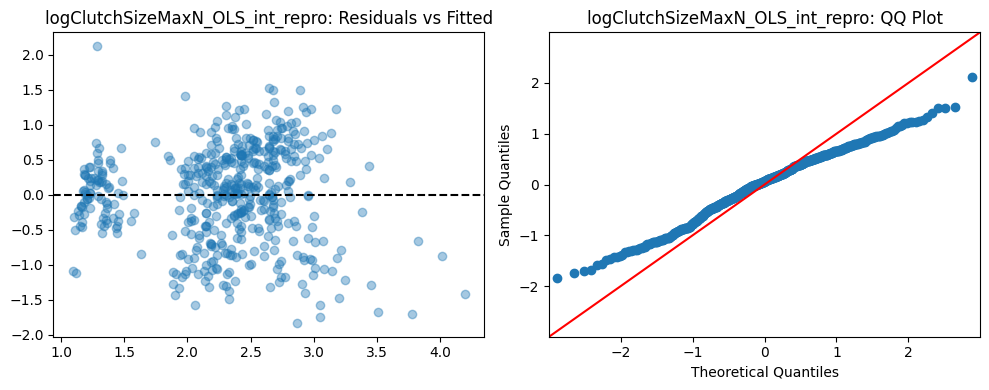

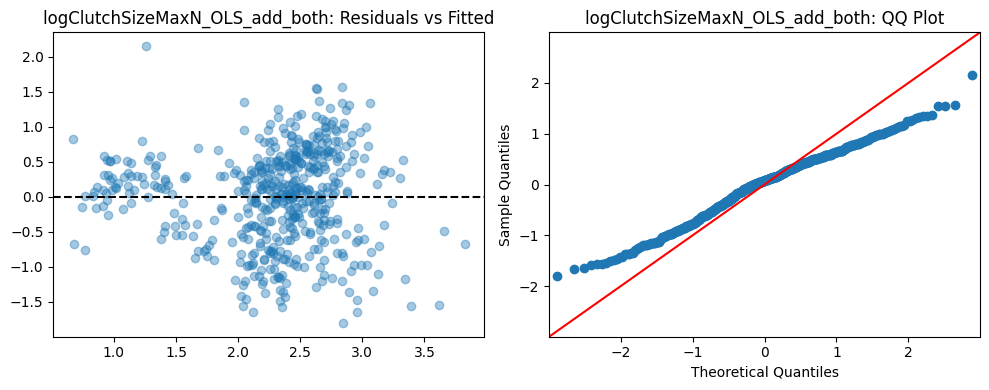

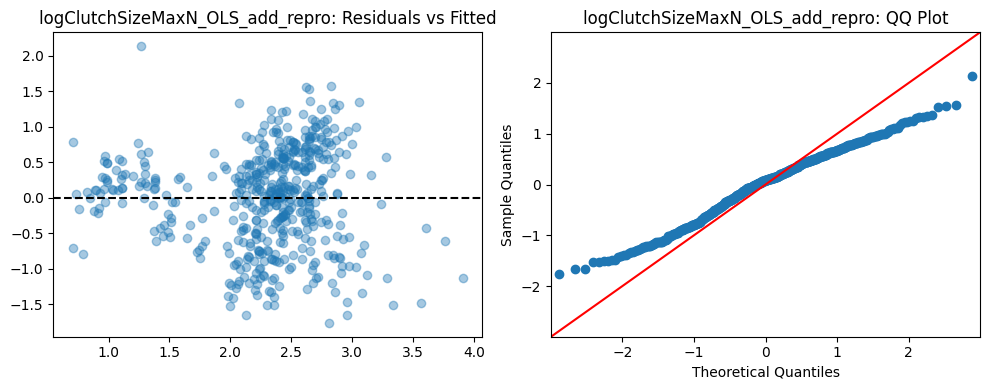

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

TOP_MODELS = diagnostics_df.query("type == 'OLS'").head(3)["model"]

for name in TOP_MODELS:
    model = models[name]
    resid = model.resid
    fitted = model.fittedvalues

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].scatter(fitted, resid, alpha=0.4)
    axes[0].axhline(0, linestyle="--", color="black")
    axes[0].set_title(f"{name}: Residuals vs Fitted")

    sm.qqplot(resid, line="45", ax=axes[1])
    axes[1].set_title(f"{name}: QQ Plot")

    plt.tight_layout()
    plt.show()

In [ ]:
# 6.5 Model Fit
"""
NOT model selection by optimization
"""

FINAL_MODELS = {
    "OLS_primary": {
        "type": "OLS",
        "formula": "logClutchSizeMaxN ~ logBodyLengthMm",
        "use_HC3": True,
        "role": "primary_inference"
    },

    "OLS_repro_adjusted": {
        "type": "OLS",
        "formula": "logClutchSizeMaxN ~ logBodyLengthMm + reproductiveMethod",
        "use_HC3": True,
        "role": "primary_inference"
    },

    "GLM_gaussian": {
        "type": "GLM",
        "family": "Gaussian",
        "link": "identity",
        "formula": "logClutchSizeMaxN ~ logBodyLengthMm",
        "role": "sensitivity_check"
    },

    "RLM_huber": {
        "type": "RLM",
        "formula": "logClutchSizeMaxN ~ logBodyLengthMm",
        "role": "sensitivity_check"
    }
}

In [ ]:
collapse_summary = []

for name, spec in FINAL_MODELS.items():
    collapse_summary.append({
        "model": name,
        "formula": spec["formula"],
        "type": spec["type"],
        "uses_HC3": spec.get("use_HC3", False),
        "role": spec["role"]
    })

collapse_df = pd.DataFrame(collapse_summary)
display(collapse_df)

,model,formula,type,uses_HC3,role
0,OLS_primary,logClutchSizeMaxN ~ logBodyLengthMm,OLS,True,primary_inference
1,OLS_repro_adjusted,logClutchSizeMaxN ~ logBodyLengthMm + reproduc...,OLS,True,primary_inference
2,GLM_gaussian,logClutchSizeMaxN ~ logBodyLengthMm,GLM,False,sensitivity_check
3,RLM_huber,logClutchSizeMaxN ~ logBodyLengthMm,RLM,False,sensitivity_check


In [ ]:
# 8) Exports
"""
- creates Exports/Assumptions/Tables + Exports/Assumptions/Figures
- exports tables if they exist in the notebook namespace
- exports representative figures if available (safe / best-effort)
No analysis is performed :)
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# paths
EXPORT_ROOT = "Exports/Assumptions"
TABLE_DIR   = os.path.join(EXPORT_ROOT, "Tables")
FIG_DIR     = os.path.join(EXPORT_ROOT, "Figures")

os.makedirs(TABLE_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# helpers
def _export_table(obj, name):
    if obj is None:
        print(f"Skip: {name}")
        return
    if not isinstance(obj, pd.DataFrame):
        try:
            obj = pd.DataFrame(obj)
        except Exception:
            print(f"Skip: {name}")
            return
    path = os.path.join(TABLE_DIR, f"{name}.csv")
    obj.to_csv(path, index=False)
    print(f"Saved table,{path}")

def _export_fig(fig, name, dpi=300):
    if fig is None:
        print(f"Skip figure (None): {name}")
        return
    path = os.path.join(FIG_DIR, f"{name}.png")
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved figure, {path}")

def _get(name):
    return globals().get(name, None)

# export tables
TABLE_EXPORTS = [
    # normality
    ("global_shapiro_df",        "Shapiro_Global_LogTraits"),
    ("group_shapiro_df",         "Shapiro_By_ReproductiveMethod"),

    # variance checks
    ("levene_df",                "Levene_By_ReproductiveMethod"),
    ("levene_hab_df",            "Levene_By_HabitatClass"),

    # chi-square screening
    ("ct_obs",                   "ChiSquare_Observed"),
    ("ct_exp",                   "ChiSquare_Expected"),
    ("summary",                  "ChiSquare_AssumptionSummary"),

    # routing + Welch validity
    ("anova_routing_df",         "ANOVA_Routing_Decisions"),
    ("welch_assumptions_df",     "Welch_ANOVA_Validity"),

    # regression diagnostics
    ("diagnostics_df",           "Regression_ModelDiagnostics"),
    ("hc3_df",                   "Regression_HC3_Comparison"),

    # model collapse
    ("collapse_df",              "Final_Model_Set"),
]

print("=== Exporting Tables ===")
for varname, outname in TABLE_EXPORTS:
    obj = _get(varname)

    if varname in ("ct_obs", "ct_exp") and obj is not None:
        if isinstance(obj, pd.DataFrame):
            obj2 = obj.reset_index()
        else:
            try:
                obj2 = pd.DataFrame(obj).reset_index()
            except Exception:
                obj2 = None
        _export_table(obj2, outname)
    else:
        _export_table(obj, outname)

print("\nExporting Figures")

# 1) Raw vs log distribution
try:
    fig_current = plt.gcf()
    if fig_current.axes:
        _export_fig(fig_current, "FIG_Raw_vs_Log_Distributions")
    else:
        print("no active matplotlib figure raw-vs-log.")
except Exception as e:
    print(f"raw-vs-log export (error): {e}")

# 2) Regression diagnostics
#   - REP_MODEL variable (if you set it)
#   - models dict: pick first OLS-like result
try:
    import statsmodels.api as sm

    rep_model = _get("REP_MODEL")

    # If REP_MODEL
    if rep_model is None:
        models_dict = _get("models")
        if isinstance(models_dict, dict) and len(models_dict) > 0:
            # pick first model
            for k, m in models_dict.items():
                if hasattr(m, "resid") and hasattr(m, "fittedvalues"):
                    rep_model = m
                    rep_name = str(k)
                    break
        else:
            rep_model = None
    else:
        rep_name = "REP_MODEL"

    if rep_model is None:
        print("No best model")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        axes[0].scatter(rep_model.fittedvalues, rep_model.resid, alpha=0.4)
        axes[0].axhline(0, linestyle="--", color="black")
        axes[0].set_title("Residuals vs Fitted")
        axes[0].set_xlabel("Fitted values")
        axes[0].set_ylabel("Residuals")

        sm.qqplot(rep_model.resid, line="45", ax=axes[1])
        axes[1].set_title("QQ Plot (Residuals)")

        plt.suptitle(f"Representative regression diagnostics ({rep_name})", y=1.05)
        plt.tight_layout()

        _export_fig(fig, "FIG_Regression_Diagnostics_Representative")

except Exception as e:
    print(f"Regress export (error): {e}")

print(f"\nTadaaaa\nTables:  {TABLE_DIR}\nFigures: {FIG_DIR}")

=== Exporting Tables ===
Saved table,Exports/Assumptions/Tables/Shapiro_Global_LogTraits.csv
Saved table,Exports/Assumptions/Tables/Shapiro_By_ReproductiveMethod.csv
Saved table,Exports/Assumptions/Tables/Levene_By_ReproductiveMethod.csv
Saved table,Exports/Assumptions/Tables/Levene_By_HabitatClass.csv
Saved table,Exports/Assumptions/Tables/ChiSquare_Observed.csv
Saved table,Exports/Assumptions/Tables/ChiSquare_Expected.csv
Saved table,Exports/Assumptions/Tables/ChiSquare_AssumptionSummary.csv
Saved table,Exports/Assumptions/Tables/ANOVA_Routing_Decisions.csv
Saved table,Exports/Assumptions/Tables/Welch_ANOVA_Validity.csv
Saved table,Exports/Assumptions/Tables/Regression_ModelDiagnostics.csv
Saved table,Exports/Assumptions/Tables/Regression_HC3_Comparison.csv
Saved table,Exports/Assumptions/Tables/Final_Model_Set.csv

Exporting Figures
no active matplotlib figure raw-vs-log.
Saved figure, Exports/Assumptions/Figures/FIG_Regression_Diagnostics_Representative.png

Tadaaaa
Tables:  Export

<Figure size 640x480 with 0 Axes>

In [ ]:
"""
Assump SUmm
• Raw traits right-skewed; log10 transformation reduced skew and stabilized variance
• Normality tests rejected strict normality (expected)
  visual diagnostics supported approximate normality of log-transformed traits
• Variance homogeneity was violated across groups
• Chi-square assumptions were satisfied for habitatClass × reproductiveMethod.
• Welch ANOVA was used for group comparisons
• Regression diagnostics indicated heteroskedasticity and influential observations;
  HC3 robust standard errors were used for OLS regression
• GLM, robust regression are other OK

These results lead to inferential method
"""

'\nAssump SUmm\n• Raw traits right-skewed; log10 transformation reduced skew and stabilized variance\n• Normality tests rejected strict normality (expected)\n  visual diagnostics supported approximate normality of log-transformed traits\n• Variance homogeneity was violated across groups\n• Chi-square assumptions were satisfied for habitatClass × reproductiveMethod.\n• Welch ANOVA was used for group comparisons\n• Regression diagnostics indicated heteroskedasticity and influential observations;\n  HC3 robust standard errors were used for OLS regression\n• GLM, robust regression are other OK\n\nThese results lead to inferential method\n'